In [26]:
#Jeg indlæser først modulerne
import re
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from cleantext import clean 
import matplotlib.pyplot as plt
from collections import Counter 
from pandarallel import pandarallel



In [27]:
#Læser data-filen
df = pd.DataFrame(pd.read_csv("news_sample.csv"))

#Vi bruger 'content' kolonnen.
my_cleaning_df = df[["content"]].copy()

In [28]:
#Funktion der gør tekst til lower-case
def all_lower(x):
    x= x.lower()
    return x

#Funktion der fjerner tegn
def remove_special_chars(x):
    import re 
    return re.sub(r"[^a-zA-Z0-9<>]", " ", x)

#Skal vi gøre det her???
auto_cleaning_df = df[["content"]].copy() #Memory???

#Funktion der erstatter datoer med <DATE>
def sub_dates(x):
    import re 
    sub_dates = re.sub(r'\d{4}[-/]\d{2}[-/]\d{2}|\d{2}[-/]\d{2}[-/]\d{4}', ' <DATE> ', x)
    sub_dates = re.sub(r'\b[a-z]+\s\d{1,2},\s\d{4}\b', '<DATE>', sub_dates)
    sub_dates = re.sub(r'\b\d{1,2}[,]?\s[a-zA-Z]+\s\d{4}\b', '<DATE>', sub_dates)
    return sub_dates

#Definerer variablen 'stopwords' som er et set af alle stopwords importeret fra modulet nltk


In [29]:
# Initialiser pandarallel
pandarallel.initialize(progress_bar=True)  #giver os en progress
pandarallel.initialize(nb_workers=4)  # Brug 4 kerner... ændr ved bluescreen

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [30]:
#Funktion til at cleane tekst
def autocleandf(df):
    from cleantext import clean 
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    df['sub_dates']=df['content'].parallel_apply(sub_dates)          #Applyer funktionen 'sub_dates' på 'content' kolonnen
    
    df['cleaned']=df['sub_dates'].parallel_apply(                    #Applyer clean funktion fra modulet cleantext.
        lambda x: clean(x, lower=True, no_urls=True, no_emails=True, no_numbers=True, no_punct=True, no_currency_symbols=True))
    
    df['tokens']=df['cleaned'].parallel_apply(lambda x: word_tokenize(x))  #Applyer word_tokenize funktion fra nltk, som laver det til en liste af strings
    
    df['filtered_tokens']=df['tokens'].parallel_apply(         #Filtrerer ord væk som er enten stopwords, 'number','date','url','email' eller <, >
        lambda x: [word for word in x if word.lower() not in stop_words and not any(word_ in word.lower() for word_ in ["number", "date", "url", "email", "<", ">"])])

autocleandf(auto_cleaning_df)

In [31]:
#Gør dataframen 'filtered_tokens' til en string
cleaned_string = ' '.join([' '.join(words) for words in auto_cleaning_df['filtered_tokens']]) 

#Gør 'cleaned_string' til en liste
cleaned_list = cleaned_string.split() 

#Gør den raw dataframe 'content' til en string
uncleaned_string = '\n'.join(df["content"].astype(str))

#Gør 'uncleaned_string' til en liste
uncleaned_list=uncleaned_string.split() 
print("antal uncleaned words",len(set(uncleaned_list)))     #Gør listen til et set så gentagne elementer kun optræder 1 gang

#Counter tæller antal gange hvert ord optræder
cleaned_antal_ord=Counter(cleaned_list)
     
print("Total wordcount after cleaning:",len(cleaned_antal_ord))

print("Procentsvis ændring:", (len(cleaned_antal_ord)/len(set(uncleaned_list)))*100 )

antal uncleaned words 30005
Total wordcount after cleaning: 16453
Procentsvis ændring: 54.83419430094985


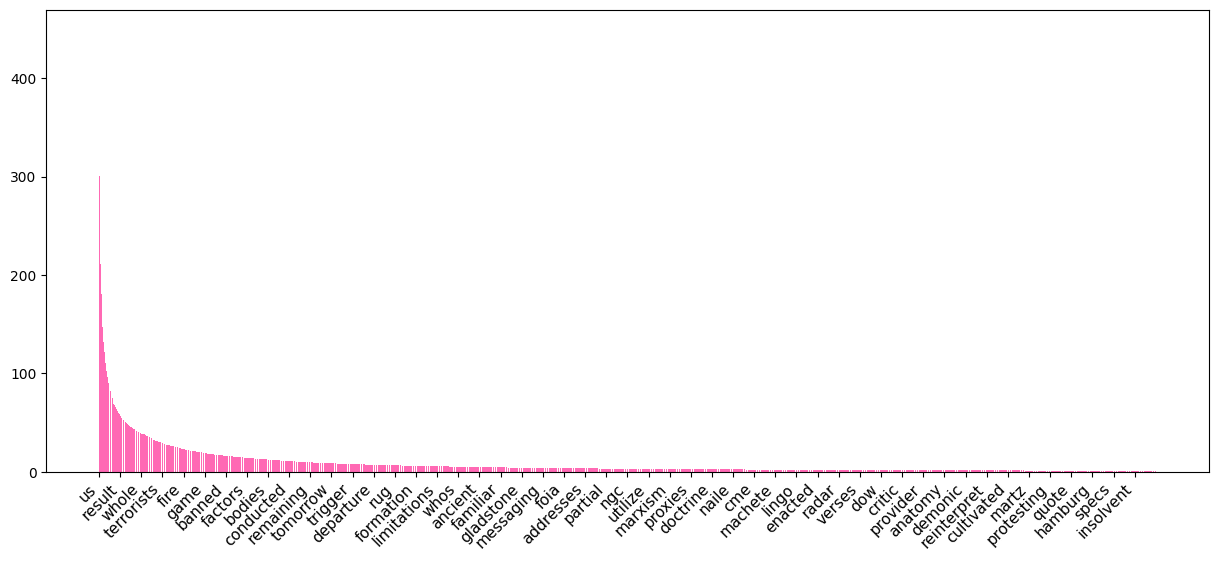

In [35]:
hypiggeste_ord = cleaned_antal_ord.most_common(10000)   #De 50 mest hyppige ord i 'ord_antal', laves til en liste mad tupler, 
                                                        #bestående af ord og ordet's hyppighed

ord = [ord for ord, tælling in hypiggeste_ord]          #Laver en liste med ordene fra 'hypiggeste_ord'. 
                                                        #Her itereres gennem hver tuple og udtrækkes ordet.
antal = [tælling for ord, tælling in hypiggeste_ord]    #Laver en liste med antal forekomster fra 'hypiggeste_ord'. 
                                                        #Her itereres gennem hver tuple og udtrækkes antal forekomster.
#Plottet
plt.figure(figsize=(15, 6))                             #Figurens højde og bredde
plt.bar(ord, antal, color = "hotpink")                  #'ord' og 'antal' sættes på x- og y-aksen i plottet
#plt.xticks(rotation=45, ha='right', fontsize=11)   
plt.xticks(range(0, len(ord), 200), ord[::200], rotation=45, ha='right', fontsize=11)
#Teksten på x-aksen roteres og tekststørrelsen vælges
plt.show() 

In [ ]:
#Stemming med modulet nltk


def stemming():
    from nltk.stem import PorterStemmer
    ps=PorterStemmer()
    auto_cleaning_df['stemmed_text']=auto_cleaning_df['cleaned'].parallel_apply(lambda x: ps.stem(x))
stemming()


In [42]:
auto_cleaning_df.head(5)

,content,sub_dates,cleaned,tokens,filtered_tokens,stemmed_text
0,Sometimes the power of Christmas will make you...,Sometimes the power of Christmas will make you...,sometimes the power of christmas will make you...,"[sometimes, the, power, of, christmas, will, m...","[sometimes, power, christmas, make, wild, wond...",sometimes the power of christmas will make you...
1,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,awakening of <number> strands of dna reconnect...,"[awakening, of, <, number, >, strands, of, dna...","[awakening, strands, dna, reconnecting, movie,...",awakening of <number> strands of dna reconnect...
2,Never Hike Alone: A Friday the 13th Fan Film U...,Never Hike Alone: A Friday the 13th Fan Film U...,never hike alone a friday the 13th fan film us...,"[never, hike, alone, a, friday, the, 13th, fan...","[never, hike, alone, friday, 13th, fan, film, ...",never hike alone a friday the 13th fan film us...
3,"When a rare shark was caught, scientists were ...","When a rare shark was caught, scientists were ...",when a rare shark was caught scientists were l...,"[when, a, rare, shark, was, caught, scientists...","[rare, shark, caught, scientists, left, blunde...",when a rare shark was caught scientists were l...
4,Donald Trump has the unnerving ability to abil...,Donald Trump has the unnerving ability to abil...,donald trump has the unnerving ability to abil...,"[donald, trump, has, the, unnerving, ability, ...","[donald, trump, unnerving, ability, ability, c...",donald trump has the unnerving ability to abil...
